In [1]:
from common.multiprocessing_env import SubprocVecEnv
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import gym
import datetime
import os
import constants as c

2023-04-15 17:44:14.732448: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-04-15 17:44:14.896406: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-15 17:44:15.668489: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from models import ActorNetwork, CriticNetwork, ActorCriticPPO, Decoder, Encoder

In [4]:
tf.config.list_physical_devices('GPU')

2023-04-15 17:44:16.986988: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-04-15 17:44:17.105588: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-04-15 17:44:17.105807: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [5]:
# convert to discrete action space with 5 actions: left, right, forward, brake, no action
# 0: left, 1: right, 2: forward, 3: brake, 4: no action
def convert_to_continuous_action(action, batch=False):
    if batch:
        return np.array([convert_to_continuous_action(a) for a in action])
    if action == 0:
        return [-1., 0., 0.]
    elif action == 1:
        return [1., 0., 0.]
    elif action == 2: # forward
        return [0., 0.8, 0.0]
    elif action == 3:
        return [0., 0., 0.8]
    elif action == 4:
        return [0., 0., 0.]    

In [6]:
def preprocess_state(state, batch=True):
    if batch:
        state = state[:, :84, ...]
    else:
        state = state[:84, ...]
    state = state / 255.0
    state = tf.image.resize(state, (64, 64),)
    return state

In [7]:
def plot(frame_idx, rewards):
    clear_output(True)
    plt.figure(figsize=(8, 5), dpi=100)
    plt.plot(np.mean(rewards, axis=1), color='blue')
    plt.fill_between(range(len(rewards)), np.min(rewards, axis=1), np.max(rewards, axis=1), color='blue', alpha=0.2)
    plt.grid()
# # plt.savefig('ppo_rewards.png', dpi=300, facecolor='grey')

#     plt.figure(figsize=(20,5), dpi=100)
#     plt.subplot(131)
    plt.title('frame %s. reward: %s' % (frame_idx, np.mean(np.mean(rewards[-10:], axis=1))))
#     plt.plot(rewards)
#     # plt.subplot(132)
#     # plt.title('loss')
#     # plt.plot(losses)
    # plt.savefig(f'./plots/{frame_idx}.png')
    plt.show()

def run_test_env(model: ActorCriticPPO, env, vis=False):
    """
    Run the environment for one episode and return the total reward.

    Args:
        model: The model to use for inference.
        env: The environment to run.
        vis: Whether to render the environment.
    """
    state = preprocess_state(env.reset(), batch=False)
    if vis: env.render()
    done = False
    total_reward = 0
    while not done:
        policy, _ = model(state[None, ...])
        #deterministic action
        action = np.argmax(policy)
        next_state, reward, done, _ = env.step(convert_to_continuous_action(action))
        if reward < 0:
            reward = -0.1
        state = preprocess_state(next_state, batch=False)
        if vis: env.render()
        total_reward += reward
    return total_reward    

In [8]:
def compute_gae(next_value, rewards, masks, values, gamma=0.99, tau=0.95):
    """
    Generalized Advantage Estimate

    Args:
        next_value: V(s_{t+1}) -- the critic's estimate of what the future state's value is
        rewards: [r_{t}, r_{t+1}, ..., r_{T-1}]
        masks: [m_{t}, m_{t+1}, ..., m_{T-1}]
        values: [V(s_{t}), V(s_{t+1}), ..., V(s_{T-1})]
        gamma: discount factor
        tau: GAE-lambda

    Returns:
        returns: [GAE_{t}, GAE_{t+1}, ..., GAE_{T-1}]
    """
    values = values + [next_value]
    gae = 0
    returns = []
    for step in reversed(range(len(rewards))):
        delta = rewards[step] + gamma * values[step + 1] * masks[step] - values[step]
        gae = delta + gamma * tau * masks[step] * gae
        returns.insert(0, gae + values[step])
    return returns

In [9]:
def ppo_iter(mini_batch_size, states, actions, log_probs, returns, advantage):
    batch_size = states.shape[0]
    # for _ in range(batch_size // mini_batch_size):
    #     rand_ids = np.random.randint(0, batch_size, mini_batch_size)
    #     yield states[rand_ids, :], actions[rand_ids, :], log_probs[rand_ids, :], returns[rand_ids, :], advantage[rand_ids, :]
    shuffle_ids = np.random.permutation(batch_size)
    for i in range(0, batch_size, mini_batch_size):
        yield tf.gather(states, shuffle_ids[i:i+mini_batch_size]), tf.gather(actions, shuffle_ids[i:i+mini_batch_size]), tf.gather(log_probs, shuffle_ids[i:i+mini_batch_size]), tf.gather(returns, shuffle_ids[i:i+mini_batch_size]), tf.gather(advantage, shuffle_ids[i:i+mini_batch_size])
        
def ppo_update(model, ppo_epochs, mini_batch_size, states, actions, log_probs, returns, advantages, clip_param=0.2):    
    for j in range(ppo_epochs):
        for state, action, old_log_probs, return_, advantage in ppo_iter(mini_batch_size, states, actions, log_probs, returns, advantages):
            with tf.GradientTape() as tape:
                probs, value = model(state)
                value = tf.squeeze(value)
                entropy = -tf.reduce_mean(tf.reduce_sum(probs * tf.math.log(probs), axis=1))
                new_log_probs = tf.math.log(tf.reduce_sum(probs * action, axis=1, keepdims=False))
                ratio = tf.exp(new_log_probs - old_log_probs)
                surr1 = ratio * advantage
                # surr2 = torch.clamp(ratio, 1.0 - clip_param, 1.0 + clip_param) * advantage # convert to tf
                surr2 = tf.clip_by_value(ratio, 1.0 - clip_param, 1.0 + clip_param) * advantage

                # actor_loss  = - torch.min(surr1, surr2).mean()
                actor_loss  = - tf.reduce_mean(tf.minimum(surr1, surr2))

                # critic_loss = (return_ - value).pow(2).mean()
                critic_loss = tf.reduce_mean(tf.square(return_ - value))

                loss = 0.8 * critic_loss + actor_loss - 0.001 * entropy

            grads = tape.gradient(loss, model.trainable_variables)
            model.optimizer.apply_gradients(zip(grads, model.trainable_variables))
        
        # log
        if j % 10 == 0:
            print(f'Epoch {j} loss: {loss.numpy()} actor_loss: {actor_loss.numpy()} critic_loss: {critic_loss.numpy()} entropy: {entropy.numpy()}')



In [10]:
num_envs = 3
env_name = "CarRacing-v0"

def make_env():
    def _thunk():
        env = gym.make(env_name)
        return env
    return _thunk

envs = [make_env() for i in range(num_envs)]
envs = SubprocVecEnv(envs)

env_test = gym.make(env_name)

input_dim = (64, 64, 3)
output_dim = 5

/home/nimahsn/Documents/RL/lusr_carracing/gym/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
/home/nimahsn/Documents/RL/lusr_carracing/gym/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
/home/nimahsn/Documents/RL/lusr_carracing/gym/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
/home/nimahsn/Documents/RL/lusr_carracing/gym/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [11]:
env_test.action_space # Steering (-1 to 1), Gas (0 to 1), Brake (0 to 1)

Box(3,)

In [12]:
actor = ActorNetwork()
critic = CriticNetwork()
encoder = Encoder(False)
encoder.build([None, 64, 64, 3])
encoder.load_weights('./encoder_weights_3.h5')
encoder.trainable = False
model = ActorCriticPPO(encoder, actor, critic)

2023-04-15 17:44:19.206226: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-04-15 17:44:19.206445: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-04-15 17:44:19.206547: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [13]:
lr = 1e-4
optimizer = tf.keras.optimizers.Adam(lr)
model.compile(optimizer=optimizer)

#Hyper params:
num_steps        = 2000
mini_batch_size  = 500
ppo_epochs       = 100
threshold_reward = -50

max_frames = 200000
frame_idx  = 0

total_rewards = []
total_returns = []
test_rewards = []

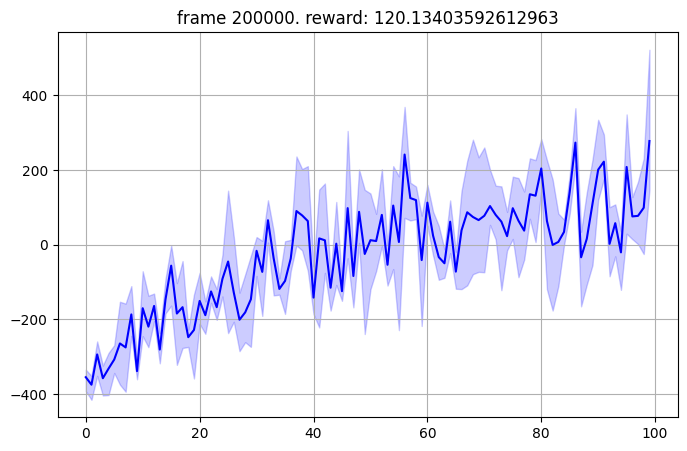

Epoch 0 loss: 37.957305908203125 actor_loss: 0.46156877279281616 critic_loss: 74.9932632446289 entropy: 0.1786353439092636
Epoch 10 loss: 20.6917781829834 actor_loss: 0.33757421374320984 critic_loss: 40.710208892822266 entropy: 0.17988629639148712
Epoch 20 loss: 15.44600772857666 actor_loss: -0.13176853954792023 critic_loss: 31.15715789794922 entropy: 0.16057062149047852
Epoch 30 loss: 13.572614669799805 actor_loss: -0.5027803778648376 critic_loss: 28.152551651000977 entropy: 0.17620590329170227
Epoch 40 loss: 12.15347957611084 actor_loss: -0.009236907586455345 critic_loss: 24.327051162719727 entropy: 0.1617802530527115
Epoch 50 loss: 9.85542106628418 actor_loss: -0.1473565548658371 critic_loss: 20.007352828979492 entropy: 0.17969810962677002
Epoch 60 loss: 9.568784713745117 actor_loss: 0.11243175715208054 critic_loss: 18.91436767578125 entropy: 0.16611897945404053
Epoch 70 loss: 8.377138137817383 actor_loss: -0.8961734175682068 critic_loss: 18.548280715942383 entropy: 0.16570203006267

In [14]:
state = preprocess_state(envs.reset(), True)
early_stop = False # set to true if the reward is above the threshold

while frame_idx < max_frames and not early_stop:

    log_probs = []
    values    = []
    states    = []
    actions   = []
    rewards   = []
    masks     = []
    entropy = 0

    for _ in range(num_steps):
        # state = state
        policy, value = model(state) # policy = [batch_size, num_actions], value = [batch_size, 1]. policy is the probability of each action
        value = tf.squeeze(value)
        action = tf.random.categorical(policy, 1).numpy()
        reward = np.array([0.0]*num_envs)
        for _ in range(4):
            next_state, reward_t, done, _ = envs.step(convert_to_continuous_action(action, True))
            rewards_t = np.where(reward_t < 0, -0.1, reward_t)
            reward += reward_t
            if done.all():
                break
        
        one_hot_action = tf.squeeze(tf.one_hot(action, output_dim))

        # calculate the log prob of the selected action based on the the policy
        log_prob = tf.math.log(tf.reduce_sum(one_hot_action * policy, axis=1))
        entropy += tf.reduce_mean(-tf.reduce_sum(policy * tf.math.log(policy), axis=1))

        log_probs.append(log_prob)
        values.append(value)
        rewards.append(reward)
        masks.append(1 - done)

        states.append(state)
        actions.append(one_hot_action)

        next_state = preprocess_state(next_state, batch=True)
        state = next_state
        frame_idx += 1

        # if frame_idx % 1000 == 0:
            # test_reward = [run_test_env(model, env_test, False) for _ in range(2)]
            # test_rewards.append(test_reward)
            # plot(frame_idx, test_rewards)
            # if test_reward > threshold_reward: early_stop = True

        # save checkpoint every 5000 frames
        if frame_idx % 5000 == 0:
            os.mkdir(f'./checkpoints_3/{frame_idx}')
            # os.mkdir(f'./checkpoints/{frame_idx}/commons')
            os.mkdir(f'./checkpoints_3/{frame_idx}/actor')
            os.mkdir(f'./checkpoints_3/{frame_idx}/critic')
            
            # model.commons.save_weights(f'./checkpoints/{frame_idx}/commons/weights.h5')
            model.actor.save_weights(f'./checkpoints_3/{frame_idx}/actor/weights.h5')
            model.critic.save_weights(f'./checkpoints_3/{frame_idx}/critic/weights.h5')


    _, next_value = model(next_state)
    next_value = tf.squeeze(next_value)
    returns = compute_gae(next_value, rewards, masks, values)

    total_rewards.append(np.sum(rewards, axis=0))
    plot(frame_idx, total_rewards)
    total_returns.append(np.sum(returns, axis=0))

    log_probs = tf.concat(log_probs, axis=0)
    returns   = tf.concat(returns, axis=0)
    values    = tf.concat(values, axis=0)
    states    = tf.concat(states, axis=0)
    actions   = tf.concat(actions, axis=0)
    advantage = tf.convert_to_tensor(returns - values)


    ppo_update(model, ppo_epochs, mini_batch_size, states, actions, log_probs, returns, advantage)
    #log 
    print(f'\nFrame_idx: {frame_idx}, entropy: {entropy.numpy()}, reward: {np.mean(rewards)}\n')

    if done.all():
        state = preprocess_state(envs.reset(), True)
        print('reset')
    else:
        state = next_state

# save the model
    

In [15]:
model.actor.save_weights('ppo_model_actor_3.h5')
model.critic.save_weights('ppo_model_critic_3.h5')

In [16]:
arr = np.array(total_returns)
#save arr
np.save('ppo_total_returns_3.npy', arr)

In [17]:
arr = np.array(total_rewards)
#save arr
np.save('ppo_total_rewards_3.npy', arr)

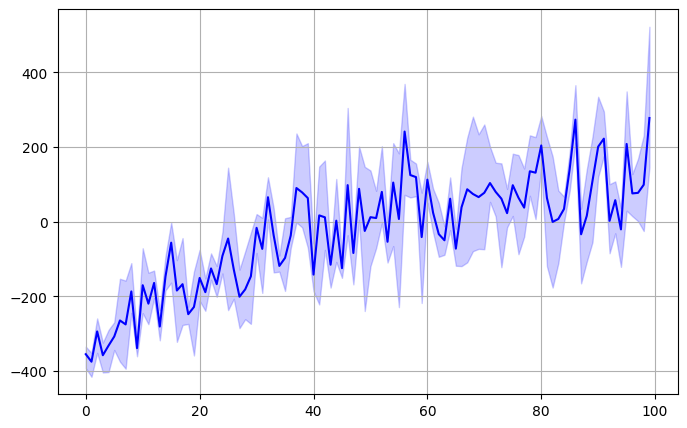

In [18]:
plt.figure(figsize=(8, 5), dpi=100)
plt.plot(np.mean(total_rewards, axis=1), color='blue')
plt.fill_between(range(len(total_rewards)), np.min(total_rewards, axis=1), np.max(total_rewards, axis=1), color='blue', alpha=0.2)
plt.grid()
plt.show()

## Resume training

In [20]:
# model.actor.build([None, c.CONTENT_LATENT_SIZE])
# model.critic.build([None, c.CONTENT_LATENT_SIZE])
# model.actor.load_weights('ppo_model_actor_3.h5')
# model.critic.load_weights('ppo_model_critic_3.h5')
# #load total_rewards and convert the outer array to a list, but the inner array is still an numpy array
# total_rewards = np.load('ppo_total_rewards_3.npy').tolist()
# total_returns = np.load('ppo_total_returns_3.npy').tolist()

In [21]:
lr = 1e-4
# optimizer = tf.keras.optimizers.Adam(lr)
# model.compile(optimizer=optimizer)

#Hyper params:
num_steps        = 3000
mini_batch_size  = 500
ppo_epochs       = 100
threshold_reward = -50

max_frames = 300000
# frame_idx  = 100000

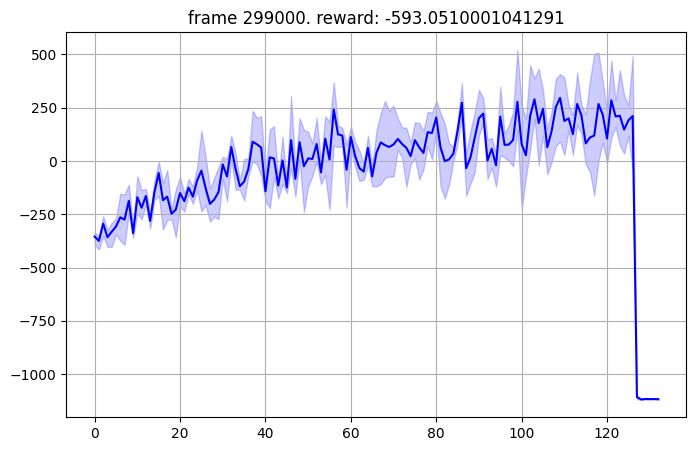

Epoch 0 loss: nan actor_loss: nan critic_loss: 3.8502697944641113 entropy: nan
Epoch 10 loss: nan actor_loss: nan critic_loss: 1.8255361318588257 entropy: nan
Epoch 20 loss: nan actor_loss: nan critic_loss: 1.4735883474349976 entropy: nan
Epoch 30 loss: nan actor_loss: nan critic_loss: 1.2951340675354004 entropy: nan
Epoch 40 loss: nan actor_loss: nan critic_loss: 0.9332205653190613 entropy: nan
Epoch 50 loss: nan actor_loss: nan critic_loss: 1.4343557357788086 entropy: nan
Epoch 60 loss: nan actor_loss: nan critic_loss: 1.5211436748504639 entropy: nan
Epoch 70 loss: nan actor_loss: nan critic_loss: 1.6475517749786377 entropy: nan
Epoch 80 loss: nan actor_loss: nan critic_loss: 1.505500078201294 entropy: nan
Epoch 90 loss: nan actor_loss: nan critic_loss: 1.4628499746322632 entropy: nan

Frame_idx: 299000, entropy: nan, reward: -0.3723696885912577



KeyboardInterrupt: 

In [22]:
state = preprocess_state(envs.reset(), True)
early_stop = False # set to true if the reward is above the threshold

while frame_idx < max_frames and not early_stop:

    log_probs = []
    values    = []
    states    = []
    actions   = []
    rewards   = []
    masks     = []
    entropy = 0

    for _ in range(num_steps):
        # state = state
        policy, value = model(state) # policy = [batch_size, num_actions], value = [batch_size, 1]. policy is the probability of each action
        value = tf.squeeze(value)
        action = tf.random.categorical(policy, 1).numpy()
        reward = np.array([0.0]*num_envs)
        for _ in range(4):
            next_state, reward_t, done, _ = envs.step(convert_to_continuous_action(action, True))
            rewards_t = np.where(reward_t < 0, -0.1, reward_t)
            reward += reward_t
            if done.all():
                break
        
        one_hot_action = tf.squeeze(tf.one_hot(action, output_dim))

        # calculate the log prob of the selected action based on the the policy
        log_prob = tf.math.log(tf.reduce_sum(one_hot_action * policy, axis=1))
        entropy += tf.reduce_mean(-tf.reduce_sum(policy * tf.math.log(policy), axis=1))

        log_probs.append(log_prob)
        values.append(value)
        rewards.append(reward)
        masks.append(1 - done)

        states.append(state)
        actions.append(one_hot_action)

        next_state = preprocess_state(next_state, batch=True)
        state = next_state
        frame_idx += 1

        # if frame_idx % 1000 == 0:
            # test_reward = [run_test_env(model, env_test, False) for _ in range(2)]
            # test_rewards.append(test_reward)
            # plot(frame_idx, test_rewards)
            # if test_reward > threshold_reward: early_stop = True

        # save checkpoint every 5000 frames
        if frame_idx % 6000 == 0:
            os.mkdir(f'./checkpoints_3/{frame_idx}')
            # os.mkdir(f'./checkpoints/{frame_idx}/commons')
            os.mkdir(f'./checkpoints_3/{frame_idx}/actor')
            os.mkdir(f'./checkpoints_3/{frame_idx}/critic')
            
            # model.commons.save_weights(f'./checkpoints/{frame_idx}/commons/weights.h5')
            model.actor.save_weights(f'./checkpoints_3/{frame_idx}/actor/weights.h5')
            model.critic.save_weights(f'./checkpoints_3/{frame_idx}/critic/weights.h5')


    _, next_value = model(next_state)
    next_value = tf.squeeze(next_value)
    returns = compute_gae(next_value, rewards, masks, values)

    total_rewards.append(np.sum(rewards, axis=0))
    plot(frame_idx, total_rewards)
    total_returns.append(np.sum(returns, axis=0))

    log_probs = tf.concat(log_probs, axis=0)
    returns   = tf.concat(returns, axis=0)
    values    = tf.concat(values, axis=0)
    states    = tf.concat(states, axis=0)
    actions   = tf.concat(actions, axis=0)
    advantage = tf.convert_to_tensor(returns - values)


    ppo_update(model, ppo_epochs, mini_batch_size, states, actions, log_probs, returns, advantage)
    #log 
    print(f'\nFrame_idx: {frame_idx}, entropy: {entropy.numpy()}, reward: {np.mean(rewards)}\n')

    if done.all():
        state = preprocess_state(envs.reset(), True)
        print('reset')
    else:
        state = next_state

# save the model
    

# recover from nan

In [30]:
model.actor.load_weights('./checkpoints_3/276000/actor/weights.h5')
model.critic.load_weights('./checkpoints_3/276000/critic/weights.h5')

In [32]:
# model.actor.save_weights('ppo_model_actor_3.h5')
# model.critic.save_weights('ppo_model_critic_3.h5')

# #save total_rewards and total_returns
# arr = np.array(total_rewards)
# np.save('ppo_total_rewards_3.npy', arr)
# arr = np.array(total_returns)
# np.save('ppo_total_returns_3.npy', arr)

## Resume Training 

In [13]:
model.actor.build([None, c.CONTENT_LATENT_SIZE])
model.critic.build([None, c.CONTENT_LATENT_SIZE])
model.actor.load_weights('ppo_model_actor_3.h5')
model.critic.load_weights('ppo_model_critic_3.h5')
#load total_rewards and convert the outer array to a list, but the inner array is still an numpy array
total_rewards = np.load('ppo_total_rewards_3.npy').tolist()
total_returns = np.load('ppo_total_returns_3.npy').tolist()

In [14]:
lr = 4e-6
optimizer = tf.keras.optimizers.Adam(lr)
model.compile(optimizer=optimizer)

#Hyper params:
num_steps        = 3000
mini_batch_size  = 500
ppo_epochs       = 100
threshold_reward = -50

max_frames = 300000
frame_idx  = 276000

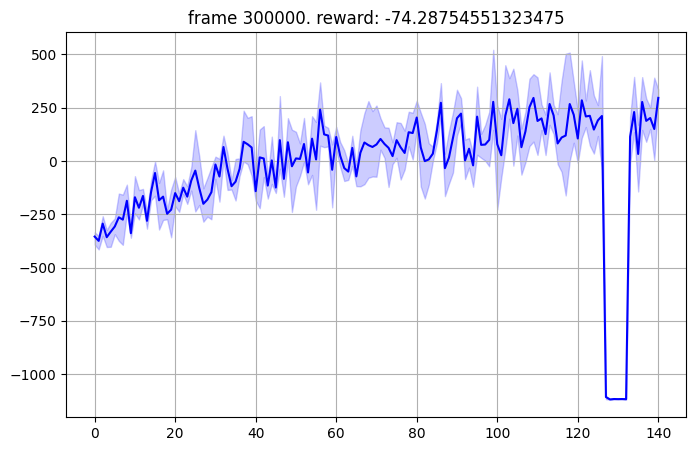

Epoch 0 loss: 21.40032958984375 actor_loss: 0.9035335183143616 critic_loss: 40.99470138549805 entropy: 0.1111508160829544
Epoch 10 loss: 20.86766815185547 actor_loss: 0.33495068550109863 critic_loss: 41.06660079956055 entropy: 0.116742804646492
Epoch 20 loss: 20.96657371520996 actor_loss: 0.5126032829284668 critic_loss: 40.90906524658203 entropy: 0.11267205327749252
Epoch 30 loss: 17.14340591430664 actor_loss: 0.11407330632209778 critic_loss: 34.05978012084961 entropy: 0.11127696931362152
Epoch 40 loss: 18.861804962158203 actor_loss: 0.24861697852611542 critic_loss: 37.227603912353516 entropy: 0.12274311482906342
Epoch 50 loss: 17.929889678955078 actor_loss: 0.1421910524368286 critic_loss: 35.5765380859375 entropy: 0.11421468108892441
Epoch 60 loss: 20.351892471313477 actor_loss: -0.31881406903266907 critic_loss: 41.342742919921875 entropy: 0.133090540766716
Epoch 70 loss: 16.6866512298584 actor_loss: 0.3370160460472107 critic_loss: 32.70046615600586 entropy: 0.11929679661989212
Epoch 

In [15]:
state = preprocess_state(envs.reset(), True)
early_stop = False # set to true if the reward is above the threshold

while frame_idx < max_frames and not early_stop:

    log_probs = []
    values    = []
    states    = []
    actions   = []
    rewards   = []
    masks     = []
    entropy = 0

    for _ in range(num_steps):
        # state = state
        policy, value = model(state) # policy = [batch_size, num_actions], value = [batch_size, 1]. policy is the probability of each action
        value = tf.squeeze(value)
        action = tf.random.categorical(policy, 1).numpy()
        reward = np.array([0.0]*num_envs)
        for _ in range(4):
            next_state, reward_t, done, _ = envs.step(convert_to_continuous_action(action, True))
            rewards_t = np.where(reward_t < 0, -0.1, reward_t)
            reward += reward_t
            if done.all():
                break
        
        one_hot_action = tf.squeeze(tf.one_hot(action, output_dim))

        # calculate the log prob of the selected action based on the the policy
        log_prob = tf.math.log(tf.reduce_sum(one_hot_action * policy, axis=1))
        entropy += tf.reduce_mean(-tf.reduce_sum(policy * tf.math.log(policy), axis=1))

        log_probs.append(log_prob)
        values.append(value)
        rewards.append(reward)
        masks.append(1 - done)

        states.append(state)
        actions.append(one_hot_action)

        next_state = preprocess_state(next_state, batch=True)
        state = next_state
        frame_idx += 1

        # if frame_idx % 1000 == 0:
            # test_reward = [run_test_env(model, env_test, False) for _ in range(2)]
            # test_rewards.append(test_reward)
            # plot(frame_idx, test_rewards)
            # if test_reward > threshold_reward: early_stop = True

        # save checkpoint every 5000 frames
        if frame_idx % 6000 == 0:
            os.mkdir(f'./checkpoints_3/{frame_idx}')
            # os.mkdir(f'./checkpoints/{frame_idx}/commons')
            os.mkdir(f'./checkpoints_3/{frame_idx}/actor')
            os.mkdir(f'./checkpoints_3/{frame_idx}/critic')
            
            # model.commons.save_weights(f'./checkpoints/{frame_idx}/commons/weights.h5')
            model.actor.save_weights(f'./checkpoints_3/{frame_idx}/actor/weights.h5')
            model.critic.save_weights(f'./checkpoints_3/{frame_idx}/critic/weights.h5')


    _, next_value = model(next_state)
    next_value = tf.squeeze(next_value)
    returns = compute_gae(next_value, rewards, masks, values)

    total_rewards.append(np.sum(rewards, axis=0))
    plot(frame_idx, total_rewards)
    total_returns.append(np.sum(returns, axis=0))

    log_probs = tf.concat(log_probs, axis=0)
    returns   = tf.concat(returns, axis=0)
    values    = tf.concat(values, axis=0)
    states    = tf.concat(states, axis=0)
    actions   = tf.concat(actions, axis=0)
    advantage = tf.convert_to_tensor(returns - values)


    ppo_update(model, ppo_epochs, mini_batch_size, states, actions, log_probs, returns, advantage)
    #log 
    print(f'\nFrame_idx: {frame_idx}, entropy: {entropy.numpy()}, reward: {np.mean(rewards)}\n')

    if done.all():
        state = preprocess_state(envs.reset(), True)
        print('reset')
    else:
        state = next_state

# save the model
    

In [16]:
model.actor.save_weights('ppo_model_actor_3.h5')
model.critic.save_weights('ppo_model_critic_3.h5')
arr = np.array(total_returns)
#save arr
np.save('ppo_total_returns_3.npy', arr)
arr = np.array(total_rewards)
#save arr
np.save('ppo_total_rewards_3.npy', arr)

## Resume Training 

In [13]:
model.actor.build([None, c.CONTENT_LATENT_SIZE])
model.critic.build([None, c.CONTENT_LATENT_SIZE])
model.actor.load_weights('ppo_model_actor_3.h5')
model.critic.load_weights('ppo_model_critic_3.h5')
#load total_rewards and convert the outer array to a list, but the inner array is still an numpy array
total_rewards = np.load('ppo_total_rewards_3.npy').tolist()
total_returns = np.load('ppo_total_returns_3.npy').tolist()

In [17]:
lr = 2e-7
optimizer = tf.keras.optimizers.Adam(lr)
model.compile(optimizer=optimizer)

#Hyper params:
num_steps        = 4000
mini_batch_size  = 500
ppo_epochs       = 100
threshold_reward = -50

max_frames = 350000
frame_idx  = 300000

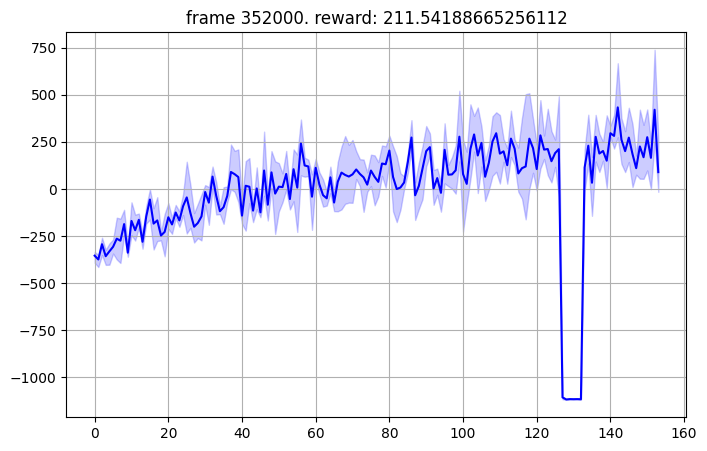

Epoch 0 loss: 20.45258903503418 actor_loss: 1.0133765935897827 critic_loss: 38.87962341308594 entropy: 0.1197638139128685
Epoch 10 loss: 23.091228485107422 actor_loss: 0.0069969939067959785 critic_loss: 46.169525146484375 entropy: 0.10603722184896469
Epoch 20 loss: 21.904146194458008 actor_loss: 0.3552546501159668 critic_loss: 43.098899841308594 entropy: 0.11161550879478455
Epoch 30 loss: 19.062530517578125 actor_loss: 0.6943905353546143 critic_loss: 36.737403869628906 entropy: 0.1124744713306427
Epoch 40 loss: 19.103443145751953 actor_loss: 0.5424327254295349 critic_loss: 37.12314224243164 entropy: 0.11211919039487839
Epoch 50 loss: 23.399126052856445 actor_loss: 0.6808822751045227 critic_loss: 45.43757629394531 entropy: 0.10863635689020157
Epoch 60 loss: 22.231544494628906 actor_loss: 0.0714004635810852 critic_loss: 44.3214111328125 entropy: 0.11215747892856598
Epoch 70 loss: 22.654239654541016 actor_loss: 0.6159906983375549 critic_loss: 44.07762908935547 entropy: 0.11332643032073975

In [18]:
state = preprocess_state(envs.reset(), True)
early_stop = False # set to true if the reward is above the threshold

while frame_idx < max_frames and not early_stop:

    log_probs = []
    values    = []
    states    = []
    actions   = []
    rewards   = []
    masks     = []
    entropy = 0

    for _ in range(num_steps):
        # state = state
        policy, value = model(state) # policy = [batch_size, num_actions], value = [batch_size, 1]. policy is the probability of each action
        value = tf.squeeze(value)
        action = tf.random.categorical(policy, 1).numpy()
        reward = np.array([0.0]*num_envs)
        for _ in range(4):
            next_state, reward_t, done, _ = envs.step(convert_to_continuous_action(action, True))
            rewards_t = np.where(reward_t < 0, -0.1, reward_t)
            reward += reward_t
            if done.all():
                break
        
        one_hot_action = tf.squeeze(tf.one_hot(action, output_dim))

        # calculate the log prob of the selected action based on the the policy
        log_prob = tf.math.log(tf.reduce_sum(one_hot_action * policy, axis=1))
        entropy += tf.reduce_mean(-tf.reduce_sum(policy * tf.math.log(policy), axis=1))

        log_probs.append(log_prob)
        values.append(value)
        rewards.append(reward)
        masks.append(1 - done)

        states.append(state)
        actions.append(one_hot_action)

        next_state = preprocess_state(next_state, batch=True)
        state = next_state
        frame_idx += 1

        # if frame_idx % 1000 == 0:
            # test_reward = [run_test_env(model, env_test, False) for _ in range(2)]
            # test_rewards.append(test_reward)
            # plot(frame_idx, test_rewards)
            # if test_reward > threshold_reward: early_stop = True

        # save checkpoint every 5000 frames
        if frame_idx % 8000 == 0:
            os.mkdir(f'./checkpoints_3/{frame_idx}')
            # os.mkdir(f'./checkpoints/{frame_idx}/commons')
            os.mkdir(f'./checkpoints_3/{frame_idx}/actor')
            os.mkdir(f'./checkpoints_3/{frame_idx}/critic')
            
            # model.commons.save_weights(f'./checkpoints/{frame_idx}/commons/weights.h5')
            model.actor.save_weights(f'./checkpoints_3/{frame_idx}/actor/weights.h5')
            model.critic.save_weights(f'./checkpoints_3/{frame_idx}/critic/weights.h5')


    _, next_value = model(next_state)
    next_value = tf.squeeze(next_value)
    returns = compute_gae(next_value, rewards, masks, values)

    total_rewards.append(np.sum(rewards, axis=0))
    plot(frame_idx, total_rewards)
    total_returns.append(np.sum(returns, axis=0))

    log_probs = tf.concat(log_probs, axis=0)
    returns   = tf.concat(returns, axis=0)
    values    = tf.concat(values, axis=0)
    states    = tf.concat(states, axis=0)
    actions   = tf.concat(actions, axis=0)
    advantage = tf.convert_to_tensor(returns - values)


    ppo_update(model, ppo_epochs, mini_batch_size, states, actions, log_probs, returns, advantage)
    #log 
    print(f'\nFrame_idx: {frame_idx}, entropy: {entropy.numpy()}, reward: {np.mean(rewards)}\n')

    if done.all():
        state = preprocess_state(envs.reset(), True)
        print('reset')
    else:
        state = next_state

# save the model
    

In [19]:
model.actor.save_weights('ppo_model_actor_3.h5')
model.critic.save_weights('ppo_model_critic_3.h5')
arr = np.array(total_returns)
#save arr
np.save('ppo_total_returns_3.npy', arr)
arr = np.array(total_rewards)
#save arr
np.save('ppo_total_rewards_3.npy', arr)

## Resume Training 

In [28]:
model.actor.build([None, c.CONTENT_LATENT_SIZE])
model.critic.build([None, c.CONTENT_LATENT_SIZE])
model.actor.load_weights('ppo_model_actor_3.h5')
model.critic.load_weights('ppo_model_critic_3.h5')
#load total_rewards and convert the outer array to a list, but the inner array is still an numpy array
total_rewards = np.load('ppo_total_rewards_3.npy').tolist()
total_returns = np.load('ppo_total_returns_3.npy').tolist()

In [29]:
lr = 2e-7
optimizer = tf.keras.optimizers.Adam(lr)
model.compile(optimizer=optimizer)

#Hyper params:
num_steps        = 5000
mini_batch_size  = 500
ppo_epochs       = 120
threshold_reward = -50

max_frames = 400000
frame_idx  = 352000

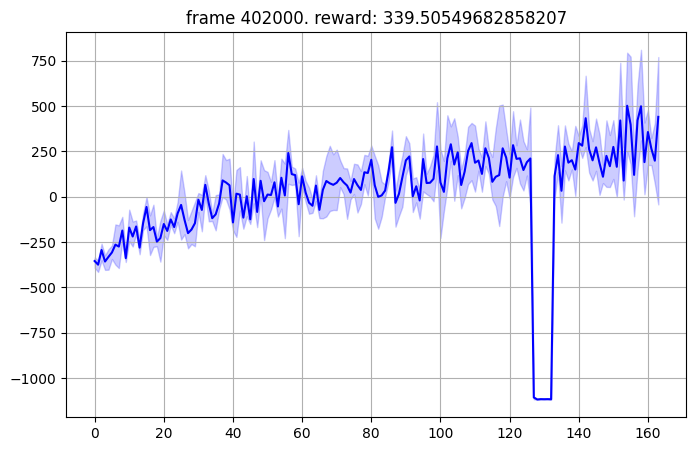

Epoch 0 loss: 26.789260864257812 actor_loss: -0.3900355100631714 critic_loss: 54.35881042480469 entropy: 0.10912550240755081
Epoch 10 loss: 25.634370803833008 actor_loss: -0.8833845257759094 critic_loss: 53.03573226928711 entropy: 0.11062397807836533
Epoch 20 loss: 24.945436477661133 actor_loss: -0.9407170414924622 critic_loss: 51.77250671386719 entropy: 0.1000589057803154
Epoch 30 loss: 23.70976448059082 actor_loss: -0.6318123936653137 critic_loss: 48.68338394165039 entropy: 0.1144077405333519
Epoch 40 loss: 25.61964225769043 actor_loss: -0.4371638298034668 critic_loss: 52.11382293701172 entropy: 0.10490584373474121
Epoch 50 loss: 22.829631805419922 actor_loss: -0.5517963171005249 critic_loss: 46.76307678222656 entropy: 0.10992296040058136
Epoch 60 loss: 25.153167724609375 actor_loss: -0.6815764904022217 critic_loss: 51.66969680786133 entropy: 0.10574053227901459
Epoch 70 loss: 23.883235931396484 actor_loss: -1.0577353239059448 critic_loss: 49.88216018676758 entropy: 0.108542755246162

In [30]:
state = preprocess_state(envs.reset(), True)
early_stop = False # set to true if the reward is above the threshold

while frame_idx < max_frames and not early_stop:

    log_probs = []
    values    = []
    states    = []
    actions   = []
    rewards   = []
    masks     = []
    entropy = 0

    for _ in range(num_steps):
        # state = state
        policy, value = model(state) # policy = [batch_size, num_actions], value = [batch_size, 1]. policy is the probability of each action
        value = tf.squeeze(value)
        action = tf.random.categorical(policy, 1).numpy()
        reward = np.array([0.0]*num_envs)
        for _ in range(4):
            next_state, reward_t, done, _ = envs.step(convert_to_continuous_action(action, True))
            rewards_t = np.where(reward_t < 0, -0.1, reward_t)
            reward += reward_t
            if done.all():
                break
        
        one_hot_action = tf.squeeze(tf.one_hot(action, output_dim))

        # calculate the log prob of the selected action based on the the policy
        log_prob = tf.math.log(tf.reduce_sum(one_hot_action * policy, axis=1))
        entropy += tf.reduce_mean(-tf.reduce_sum(policy * tf.math.log(policy), axis=1))

        log_probs.append(log_prob)
        values.append(value)
        rewards.append(reward)
        masks.append(1 - done)

        states.append(state)
        actions.append(one_hot_action)

        next_state = preprocess_state(next_state, batch=True)
        state = next_state
        frame_idx += 1

        # if frame_idx % 1000 == 0:
            # test_reward = [run_test_env(model, env_test, False) for _ in range(2)]
            # test_rewards.append(test_reward)
            # plot(frame_idx, test_rewards)
            # if test_reward > threshold_reward: early_stop = True

        # save checkpoint every 5000 frames
        if frame_idx % 10000 == 0:
            os.mkdir(f'./checkpoints_3/{frame_idx}')
            # os.mkdir(f'./checkpoints/{frame_idx}/commons')
            os.mkdir(f'./checkpoints_3/{frame_idx}/actor')
            os.mkdir(f'./checkpoints_3/{frame_idx}/critic')
            
            # model.commons.save_weights(f'./checkpoints/{frame_idx}/commons/weights.h5')
            model.actor.save_weights(f'./checkpoints_3/{frame_idx}/actor/weights.h5')
            model.critic.save_weights(f'./checkpoints_3/{frame_idx}/critic/weights.h5')


    _, next_value = model(next_state)
    next_value = tf.squeeze(next_value)
    returns = compute_gae(next_value, rewards, masks, values)

    total_rewards.append(np.sum(rewards, axis=0))
    plot(frame_idx, total_rewards)
    total_returns.append(np.sum(returns, axis=0))

    log_probs = tf.concat(log_probs, axis=0)
    returns   = tf.concat(returns, axis=0)
    values    = tf.concat(values, axis=0)
    states    = tf.concat(states, axis=0)
    actions   = tf.concat(actions, axis=0)
    advantage = tf.convert_to_tensor(returns - values)


    ppo_update(model, ppo_epochs, mini_batch_size, states, actions, log_probs, returns, advantage)
    #log 
    print(f'\nFrame_idx: {frame_idx}, entropy: {entropy.numpy()}, reward: {np.mean(rewards)}\n')

    if done.all():
        state = preprocess_state(envs.reset(), True)
        print('reset')
    else:
        state = next_state

# save the model
    

In [33]:
model.actor.save_weights('ppo_model_actor_3.h5')
model.critic.save_weights('ppo_model_critic_3.h5')
arr = np.array(total_returns)
#save arr
np.save('ppo_total_returns_3.npy', arr)
arr = np.array(total_rewards)
#save arr
np.save('ppo_total_rewards_3.npy', arr)

#### Copy saved at frame 402000

## Resume Training 

In [20]:
model.actor.build([None, c.CONTENT_LATENT_SIZE])
model.critic.build([None, c.CONTENT_LATENT_SIZE])
model.actor.load_weights('ppo_model_actor_3.h5')
model.critic.load_weights('ppo_model_critic_3.h5')
#load total_rewards and convert the outer array to a list, but the inner array is still an numpy array
total_rewards = np.load('ppo_total_rewards_3.npy').tolist()
total_returns = np.load('ppo_total_returns_3.npy').tolist()

In [21]:
lr = 6e-8
optimizer = tf.keras.optimizers.Adam(lr)
model.compile(optimizer=optimizer)

#Hyper params:
num_steps        = 6000
mini_batch_size  = 500
ppo_epochs       = 120
threshold_reward = -50

max_frames = 450000
frame_idx  = 402000

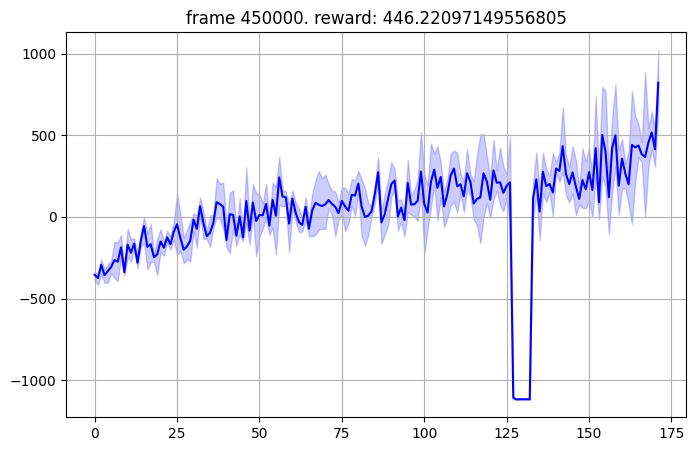

Epoch 0 loss: 30.443532943725586 actor_loss: -0.9534372091293335 critic_loss: 62.79413986206055 entropy: 0.09919454902410507
Epoch 10 loss: 27.19918441772461 actor_loss: -1.5060864686965942 critic_loss: 57.41075897216797 entropy: 0.10944565385580063
Epoch 20 loss: 25.407596588134766 actor_loss: -0.7495037317276001 critic_loss: 52.314414978027344 entropy: 0.10755794495344162
Epoch 30 loss: 31.815134048461914 actor_loss: -1.2639068365097046 critic_loss: 66.1583023071289 entropy: 0.11034329980611801
Epoch 40 loss: 28.044767379760742 actor_loss: -1.2153306007385254 critic_loss: 58.52042007446289 entropy: 0.1119348481297493
Epoch 50 loss: 27.906354904174805 actor_loss: -1.126062273979187 critic_loss: 58.06505584716797 entropy: 0.11118337512016296
Epoch 60 loss: 26.170135498046875 actor_loss: -0.8122751712799072 critic_loss: 53.965049743652344 entropy: 0.11360973119735718
Epoch 70 loss: 23.5013427734375 actor_loss: -0.9428015351295471 critic_loss: 48.888519287109375 entropy: 0.11353021115064

In [22]:
state = preprocess_state(envs.reset(), True)
early_stop = False # set to true if the reward is above the threshold

while frame_idx < max_frames and not early_stop:

    log_probs = []
    values    = []
    states    = []
    actions   = []
    rewards   = []
    masks     = []
    entropy = 0

    for _ in range(num_steps):
        # state = state
        policy, value = model(state) # policy = [batch_size, num_actions], value = [batch_size, 1]. policy is the probability of each action
        value = tf.squeeze(value)
        action = tf.random.categorical(policy, 1).numpy()
        reward = np.array([0.0]*num_envs)
        for _ in range(4):
            next_state, reward_t, done, _ = envs.step(convert_to_continuous_action(action, True))
            rewards_t = np.where(reward_t < 0, -0.1, reward_t)
            reward += reward_t
            if done.all():
                break
        
        one_hot_action = tf.squeeze(tf.one_hot(action, output_dim))

        # calculate the log prob of the selected action based on the the policy
        log_prob = tf.math.log(tf.reduce_sum(one_hot_action * policy, axis=1))
        entropy += tf.reduce_mean(-tf.reduce_sum(policy * tf.math.log(policy), axis=1))

        log_probs.append(log_prob)
        values.append(value)
        rewards.append(reward)
        masks.append(1 - done)

        states.append(state)
        actions.append(one_hot_action)

        next_state = preprocess_state(next_state, batch=True)
        state = next_state
        frame_idx += 1

        # if frame_idx % 1000 == 0:
            # test_reward = [run_test_env(model, env_test, False) for _ in range(2)]
            # test_rewards.append(test_reward)
            # plot(frame_idx, test_rewards)
            # if test_reward > threshold_reward: early_stop = True

        # save checkpoint every 5000 frames
        if frame_idx % 6000 == 0:
            os.mkdir(f'./checkpoints_3/{frame_idx}')
            # os.mkdir(f'./checkpoints/{frame_idx}/commons')
            os.mkdir(f'./checkpoints_3/{frame_idx}/actor')
            os.mkdir(f'./checkpoints_3/{frame_idx}/critic')
            
            # model.commons.save_weights(f'./checkpoints/{frame_idx}/commons/weights.h5')
            model.actor.save_weights(f'./checkpoints_3/{frame_idx}/actor/weights.h5')
            model.critic.save_weights(f'./checkpoints_3/{frame_idx}/critic/weights.h5')


    _, next_value = model(next_state)
    next_value = tf.squeeze(next_value)
    returns = compute_gae(next_value, rewards, masks, values)

    total_rewards.append(np.sum(rewards, axis=0))
    plot(frame_idx, total_rewards)
    total_returns.append(np.sum(returns, axis=0))

    log_probs = tf.concat(log_probs, axis=0)
    returns   = tf.concat(returns, axis=0)
    values    = tf.concat(values, axis=0)
    states    = tf.concat(states, axis=0)
    actions   = tf.concat(actions, axis=0)
    advantage = tf.convert_to_tensor(returns - values)


    ppo_update(model, ppo_epochs, mini_batch_size, states, actions, log_probs, returns, advantage)
    #log 
    print(f'\nFrame_idx: {frame_idx}, entropy: {entropy.numpy()}, reward: {np.mean(rewards)}\n')

    if done.all():
        state = preprocess_state(envs.reset(), True)
        print('reset')
    else:
        state = next_state

# save the model
    

In [24]:
model.actor.save_weights('ppo_model_actor_3.h5')
model.critic.save_weights('ppo_model_critic_3.h5')
arr = np.array(total_returns)
#save arr
np.save('ppo_total_returns_3.npy', arr)
arr = np.array(total_rewards)
#save arr
np.save('ppo_total_rewards_3.npy', arr)

### Remove nans from total rewards

In [74]:
# model.actor.build([None, c.CONTENT_LATENT_SIZE])
# model.critic.build([None, c.CONTENT_LATENT_SIZE])
# model.actor.load_weights('ppo_model_actor_3.h5')
# model.critic.load_weights('ppo_model_critic_3.h5')
# #load total_rewards and convert the outer array to a list, but the inner array is still an numpy array
# total_rewards = np.load('ppo_total_rewards_3.npy').tolist()
# total_returns = np.load('ppo_total_returns_3.npy').tolist()

In [75]:
# # get the index of total rewards lower than -600
# idx = [i for i, x in enumerate(np.array(total_rewards)[:, 0]) if x < -600]
# # remove idx from total_rewards and total_returns
# total_rewards = [total_rewards[i] for i in range(len(total_rewards)) if i not in idx]
# total_returns = [total_returns[i] for i in range(len(total_returns)) if i not in idx]

In [77]:
# #save arr
# np.save('ppo_total_returns_3.npy', arr)
# arr = np.array(total_rewards)
# #save arr
# np.save('ppo_total_rewards_3.npy', arr)

## Smooth rewards

In [13]:
model.actor.build([None, c.CONTENT_LATENT_SIZE])
model.critic.build([None, c.CONTENT_LATENT_SIZE])
model.actor.load_weights('ppo_model_actor_3.h5')
model.critic.load_weights('ppo_model_critic_3.h5')
#load total_rewards and convert the outer array to a list, but the inner array is still an numpy array
total_rewards = np.load('ppo_total_rewards_3.npy').tolist()
total_returns = np.load('ppo_total_returns_3.npy').tolist()

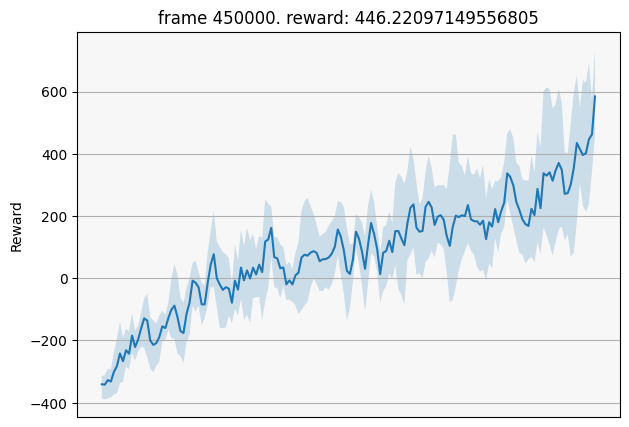

In [41]:
def smooth_plot(rewards, frame_idx, n=5):
    plt.figure(figsize=(7, 5), dpi=100)
    plt.title(f'frame {frame_idx}')
    plt.plot(moving_average(np.mean(rewards, axis=1), n))
    plt.fill_between(np.arange(len(rewards))[:-n+1], moving_average(np.min(rewards, axis=1), n), moving_average(np.max(rewards, axis=1), n), alpha=0.2)
    plt.ylabel('Reward')
    plt.grid()
    plt.xticks([], [])
    plt.title('frame %s. reward: %s' % (frame_idx, np.mean(np.mean(rewards[-10:], axis=1))))
    # set backgtround color to very light grey
    plt.gca().set_facecolor((0.97, 0.97, 0.97))
    plt.show()
    

def moving_average(x, n):
    return np.convolve(x, np.ones((n,))/n, mode='valid')

smooth_plot(total_rewards, 450000, n=3)